# 整数長ジョブシーケンス問題

こちらでは、[Lucas, 2014, "Ising formulations of many NP problems"](https://doi.org/10.3389/fphy.2014.00005)の 6.3. Job Sequencing with Integer Lengths を OpenJij と [JijModeling](https://www.ref.documentation.jijzept.com/jijmodeling/)、そしてommx-openjij-adapter を用いて解く方法をご紹介します。

## 概要: 整数長ジョブシーケンス問題とは

タスク1は実行するのに1時間、タスク2は実行に3時間、というように、整数の長さを持つタスクがいくつかあったとします。
これらを複数の実行するコンピュータに配分するとき、偏りを作ることなくコンピュータの実行時間を分散させるにはどのような組合せがあるでしょうか、というのを考える問題です。

### 具体例

分かりやすくするために具体的に以下のような状況を考えてみましょう。 

> ここに10個のタスクと3個のコンピュータがあります。10個の仕事の長さはそれぞれ$1, 2, \dots, 10$とします。
> これらのタスクをどのようにコンピュータに仕事を割り振れば仕事にかかる時間の最大値を最小化できるか考えます。
> この場合、例えば1つ目のコンピュータには9, 10、2つ目には1, 2, 7, 8、3つ目には3, 4, 5, 6とするととなり、3つのコンピュータの実行時間の最大値は19となり、これが最適解です。

![](../../../assets/integer_jobs_01.png)

### 問題の一般化

$N$個のタスク$\{0, 1, \dots, N-1\}$と$M$個のコンピュータ$\{0, 1, \dots, M-1\}$を考えましょう。各タスクの実行にかかる時間のリストを$\bm{L} = \{L_0, L_1, \dots, L_{N-1}\}$とします。
$j$番目のコンピュータで実行される仕事の集合を$V_j$としたとき、コンピュータ$j$でタスクを終えるまでの時間は$A_j = \sum_{i \in V_j} L_i$となります。
$i$番目のタスクをコンピュータ$j$で行うことを表すバイナリ変数を$x_{i, j}$とします。

**制約: タスクはどれか1つのコンピュータで実行されなければならない**

例えば、タスク3をコンピュータ1と2の両方で実行することは許されません。これを数式にすると

$$
\sum_{j=0}^{M-1} x_{i, j} = 1 \quad (\forall i \in \{ 0, 1, \dots, N-1 \})
\tag{1}
$$

**目的関数: コンピュータ1の実行時間と他の実行時間の差を小さくする**

コンピュータ1の実行時間を基準とし、それと他のコンピュータの実行時間の差を最小にすることを考えます。これにより実行時間のばらつきが抑えられ、タスクが分散されるようになります。

$$
\min\left\{ \sum_{j=1}^{M-1} (A_1 -A_j)^2\right\} 
\tag{2}
$$

## JijModelingを用いた実装

### 変数の定義

式(1), (2)で用いられている変数を、以下のようにして定義しましょう。

In [1]:
import jijmodeling as jm

# defin variables
L = jm.Placeholder("L", ndim=1)
N = L.len_at(0, latex="N")
M = jm.Placeholder("M")
x = jm.BinaryVar("x", shape=(N, M))
i = jm.Element("i", belong_to=(0, N))
j = jm.Element("j", belong_to=(0, M))

`L=jm.Placeholder('L', ndim=1)`でコンピュータに実行させるタスクの実行時間のリストを定義します。
そのリストの長さを`N=L.len_at(0, latex="N")`として定義します。`M`はコンピュータの台数、`x`はバイナリ変数です。
最後に$x_{i, j}$のように、変数の添字として使うものを`i, j`として定義します。

### 制約と目的関数の実装

式(1), (2)を実装しましょう。

In [2]:
# set problem
problem = jm.Problem('Integer Jobs')
# set constraint: job must be executed using a certain node
problem += jm.Constraint('onehot', x[i, :].sum()==1, forall=i)
# set objective function: minimize difference between node 0 and others
problem += jm.sum((j, j!=0), jm.sum(i, L[i]*(x[i, 0]-x[i, j]))**2)

`x[i, :].sum()`とすることで、$\sum_j x_{i, j}$を簡潔に実装することができます。

実装した数式をJupyter Notebookで表示してみましょう。

In [3]:
problem

### インスタンスの作成

インスタンスを以下のようにします。

In [4]:
# set a list of jobs
inst_L = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# set the number of Nodes
inst_M = 3
instance_data = {'L': inst_L, 'M': inst_M}

先程の具体例と同様に、$\{1, 2, \dots, 10\}$の10個のタスクを、3台のコンピュータに分散させる状況を考えます。

In [14]:
import jijmodeling as jm

# compile
instance = jm.Interpreter(instance_data).eval_problem(problem)
# get qubo model
qubo, const = instance.to_qubo(uniform_penalty_weight=8.0)

### OpenJijによる最適化計算の実行

今回はOpenJijのシミュレーテッド・アニーリングを用いて、最適化問題を解いてみましょう。

In [18]:
import openjij as oj

# set sampler
sampler = oj.SASampler()
# solve problem
response = sampler.sample_qubo(qubo, num_reads=100, beta_max=100)

`SASampler`を設定し、そのサンプラーに先程作成したQUBOモデルの`qubo`を入力することで、計算結果が得られます。

### デコードと解の表示

計算結果をデコードします。
また実行可能解の中から目的関数値が最小のものを選び出してみましょう。

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import ommx_openjij_adapter as oj_ad

sampleset = oj_ad.OMMXOpenJijSAAdapter(instance).decode_to_sampleset(response)
x_result = sampleset.best_feasible_unrelaxed().extract_decision_variables("x")

このようにして得られた結果から、タスク実行が分散されている様子を見てみましょう。

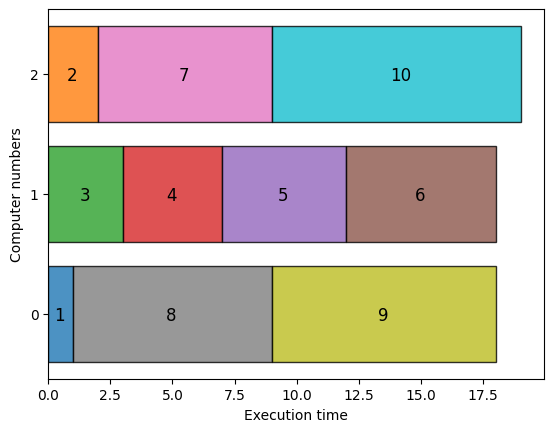

In [22]:
# get the solution of the lowest index
x_indices = {k: v for k, v in x_result.items() if v > 0.5}
# get the instance information
L = instance_data["L"]
M = instance_data["M"]
# initialize execution time
exec_time = np.zeros(M, dtype=np.int64)
# compute summation of execution time each nodes
for i, j in x_indices:
    plt.barh(j, L[i], left=exec_time[j], ec="k", linewidth=1, alpha=0.8)
    plt.text(exec_time[j] + L[i] / 2.0 - 0.25, j - 0.05, str(i + 1), fontsize=12)
    exec_time[j] += L[i]
plt.yticks(range(M))
plt.ylabel("Computer numbers")
plt.xlabel("Execution time")
plt.show()

3つのコンピュータの実行時間がほぼ均等な解が得られました。